## Grover

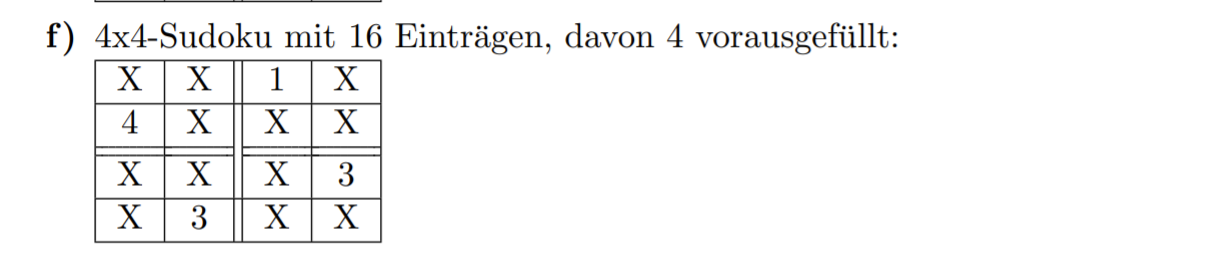

In [48]:
import utils
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [49]:
row_num = 4
column_num = 4
k_max = max(row_num, column_num)

num_sub_row = 2
num_sub_column = 2
block_size = 2

In [50]:
# known values
known_vars = {}

known_vars[(0,2)] = 0
known_vars[(1,0)] = 3
known_vars[(2,3)] = 2
known_vars[(3,1)] = 2


In [51]:
all_vars = utils.get_all_vars(row_num, column_num, k_max)
var_list = utils.get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = utils.get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [52]:
print(len(prunned_list))
prunned_list

kastchen_list = []
appender = []

remember = prunned_list[0]
for tupel in prunned_list:
    if (tupel[0] != remember[0] or tupel[1] != remember[1]):
        remember = tupel
        kastchen_list.append(appender)
        appender = []
        appender.append(tupel)
    else:
        appender.append(tupel)
kastchen_list.append(appender)

24


In [53]:
richtige_loesung = ((0, 0, 2),
 (0, 1, 1),
 (0, 3, 3),
 (1, 1, 0),
 (1, 2, 2),
 (1, 3, 1),
 (2, 0, 0),
 (2, 1, 3),
 (2, 2, 1),
 (3, 0, 1),
 (3, 2, 3),
 (3, 3, 0))

In [54]:
import itertools
belegungen = list(itertools.product(*kastchen_list))
print('Number of möglichen Lösungen: ' + str(len(belegungen)))

Number of möglichen Lösungen: 2304


In [55]:
import math
num_qubits = math.ceil(np.log2(2304))
print('Number of qubits für Kodierung: ' + str(num_qubits))

Number of qubits für Kodierung: 12


In [56]:
def belegung_to_matrix(row_num, column_num, belegung, known_vars):
    for tupel in belegung:
        known_vars[(tupel[0],tupel[1])] = tupel[2]
    sudoku = np.zeros((row_num, column_num))
    for i in range(row_num):
        for j in range(column_num):
            sudoku[i][j] = known_vars[(i,j)] + 1
    return np.asmatrix(sudoku)

In [57]:
richtige_sudoku = belegung_to_matrix(row_num, column_num, richtige_loesung, known_vars) 
print(richtige_sudoku)

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]


----------

In [58]:
#Quantum Gate Model
from qiskit import IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit.aqua.operators import EvolvedOp
from qiskit.opflow import CircuitOp
from qiskit.optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit.optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import qiskit.extensions as q_ext

In [59]:
def check_funktion_bad(check_solution, richtige_loesung):
        return int(check_solution == richtige_loesung)
    
def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)


def get_bin(x, n=0):
    """
    Get the binary representation of x.

    Parameters
    ----------
    x : int
    n : int
        Minimum number of digits. If x needs less digits in binary, the rest
        is filled with zeros.

    Returns
    -------
    str
    """
    return format(x, 'b').zfill(n)

In [60]:
def get_oracel_matrix(num_qubits, belegungen, richtige_loesung):
    U = np.eye(2**num_qubits)
    for i, belegung in enumerate(belegungen):
        U[i][i] = (-1)**check_funktion_bad(belegung, richtige_loesung)
    U = np.asmatrix(U)
    return U

In [61]:
is_unitary(get_oracel_matrix(num_qubits, belegungen, richtige_loesung))

True

In [62]:
def get_oracel_gate(oracel_matrix):
    oracel_gate = q_ext.UnitaryGate(oracel_matrix, label = 'Oracel')  
    return oracel_gate

In [63]:
from qiskit.circuit.library.standard_gates import XGate, YGate, ZGate

def oracel_gate_hardgecodet(num_qubits, belegungen, richtige_loesung):
    ind_richtig = belegungen.index(richtige_loesung)
    binary_ind = get_bin(ind_richtig, n=num_qubits)
    oracel_gate = XGate().control(num_ctrl_qubits=num_qubits, label='Oracel', ctrl_state=binary_ind)
    return oracel_gate

In [64]:
def get_circuit(num_qubits, belegungen, richtige_loesung):
    all_reg = list(np.arange(0, num_qubits+1, dtype=np.int32))
    qc = QuantumCircuit(num_qubits+1, num_qubits)
    
    qc.x([num_qubits])
    
    # creating a superposition
    for q in all_reg:
        qc.h(q)
    
        
    oracel_matrix = get_oracel_matrix(num_qubits, belegungen, richtige_loesung)
    oracel_gate = oracel_gate_hardgecodet(num_qubits, belegungen, richtige_loesung)
    #oracel_gate = get_oracel_gate(oracel_matrix)  
    num_of_itteration = math.ceil(np.pi/4*np.sqrt(len(belegungen)))  
    diffuser_null = XGate().control(num_ctrl_qubits=num_qubits, label='Diffuser', ctrl_state='0'*num_qubits)
    
    for i in range(num_of_itteration):
        #oracel
        qc.append(oracel_gate, all_reg)
        
        # diffuser
        for q in all_reg:
            qc.h(q)
        qc.append(diffuser_null, all_reg)
        # diffuser
        for q in all_reg:
            qc.h(q)
    mes_reg = list(np.arange(0, num_qubits, dtype=np.int32))
    qc.measure(mes_reg, mes_reg)
    return qc

In [65]:
qc = get_circuit(num_qubits, belegungen, richtige_loesung)

In [72]:
qc.draw()

┌───┐      Oracel ┌───┐ Diffuser ┌───┐ Oracel ┌───┐ Diffuser ┌───┐»
 q_0: ┤ H ├────────■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_1: ┤ H ├────────o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_2: ┤ H ├────────o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_3: ┤ H ├────────■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_4: ┤ H ├────────o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_5: ┤ H ├────────o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_6: ┤ H ├────────o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_7: ┤ H ├────────■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_8: ┤ H ├────────■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
 q_9: ┤ H ├────────■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
q_10: ┤ H ├────────■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├»
      ├───┤        │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤»
q_11: ┤ H ├────────o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├»
      ├───┤┌───┐ ┌─┴─┐  ├───┤  ┌─┴─┐   ├───┤ ┌─┴─┐  ├───┤  ┌─┴─┐   ├───┤»
q_12: ┤ X ├┤ H ├─┤ X ├──┤ H ├──┤ X ├───┤ H ├─┤ X ├──┤ H ├──┤ X ├───┤ H ├»
      └───┘└───┘ └───┘  └───┘  └───┘   └───┘ └───┘  └───┘  └───┘   └───┘»
c: 12/══════════════════════════════════════════════════════════════════»
                                                                        »
«       Oracel ┌───┐ Diffuser ┌───┐ Oracel ┌───┐ Diffuser ┌───┐ Oracel ┌───┐»
« q_0: ───■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├───■────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_1: ───o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├───o────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_2: ───o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├───o────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_3: ───■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├───■────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_4: ───o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├───o────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_5: ───o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├───o────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_6: ───o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├───o────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_7: ───■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├───■────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_8: ───■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├───■────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
« q_9: ───■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├───■────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
«q_10: ───■────┤ H ├────o─────┤ H ├───■────┤ H ├────o─────┤ H ├───■────┤ H ├»
«         │    ├───┤    │     ├───┤   │    ├───┤    │     ├───┤   │    ├───┤»
«q_11: ───o────┤ H ├────o─────┤ H ├───o────┤ H ├────o─────┤ H ├───

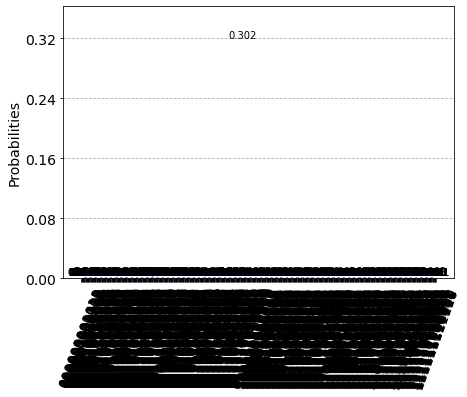

In [66]:
#backend = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('aer_simulator_statevector')
shots = 1000
job = execute(qc, backend, shots = shots)
plot_histogram(job.result().get_counts(qc))

In [67]:
result = job.result().get_counts(qc).most_frequent()

In [68]:
result

'011110001001'

In [69]:
solution = belegung_to_matrix(row_num, column_num, belegungen[int(result, 2)], known_vars)
print(solution)

[[3. 2. 1. 4.]
 [4. 1. 3. 2.]
 [1. 4. 2. 3.]
 [2. 3. 4. 1.]]


In [70]:
belegungen[int(result, 2)]

((0, 0, 2),
 (0, 1, 1),
 (0, 3, 3),
 (1, 1, 0),
 (1, 2, 2),
 (1, 3, 1),
 (2, 0, 0),
 (2, 1, 3),
 (2, 2, 1),
 (3, 0, 1),
 (3, 2, 3),
 (3, 3, 0))